https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [4]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [5]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Tune model

In [61]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [62]:
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [63]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation



18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
pred = auto_model.predict(test[['ds']])

In [10]:
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 207713.32
RMSE: 455.76
MAE: 335.40
MAPE: 77.60
SMAPE: 103.61


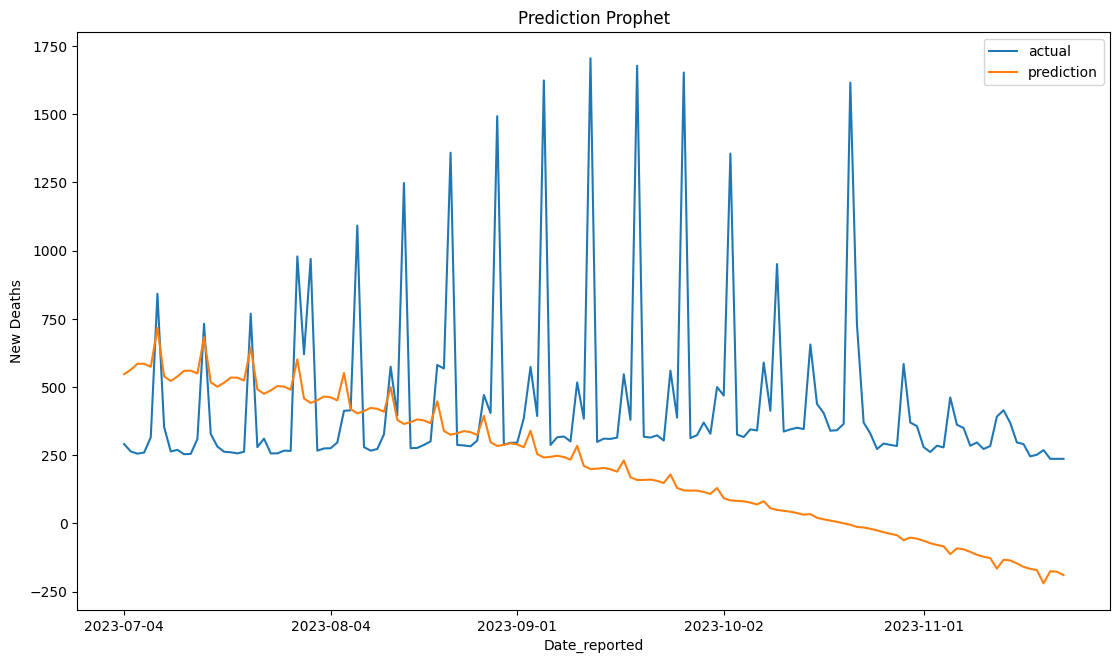

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [7]:
store_model(auto_model, "prophet")

In [68]:
# Create a copy of the data
data_log = train.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2020-01-03,0,5.463832
1,2020-01-04,0,5.463832
2,2020-01-05,0,5.472271
3,2020-01-06,0,5.463832
4,2020-01-07,0,5.463832


In [69]:
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative'}

In [70]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation

18:36:49 - cmdstanpy - INFO - Chain [1] start processing


18:36:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] done processing
18:36:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
18:36:50 - cmdstanpy - INFO - Chain [1] start processing
1

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.498985  1.580818  1.417243  0.181132  0.183508  0.162636   

   coverage  
0  0.222222  


18:37:00 - cmdstanpy - INFO - Chain [1] start processing
18:37:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing
18:37:01 - cmdstanpy - INFO - Chain [1] done 

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  2.86103  1.691458  1.483015  0.188331  0.193179  0.168086  0.236667


18:37:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:37:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
18:3

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.653876  1.629072  1.459846  0.186528  0.188153  0.166968   

   coverage  
0  0.206667  


18:37:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
18:37:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
18:37:52 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:3

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.336741  1.826675  1.596345  0.201954  0.209659  0.178868   

   coverage  
0  0.236667  


18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:38:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
18:3

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.731393  1.652693  1.481319  0.189188  0.191753  0.169118   

   coverage  
0  0.208889  


18:38:12 - cmdstanpy - INFO - Chain [1] start processing
18:38:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
18:38:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
Optimiz

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.442499  1.855397  1.628172  0.206158  0.216345  0.182256   

   coverage  
0  0.223333  


18:38:22 - cmdstanpy - INFO - Chain [1] start processing
18:38:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] done processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] done processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - ERROR - Chain [1] err

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  2.725464  1.650898  1.475484  0.188648  0.19051  0.168572  0.211111


18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
18:

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  3.30646  1.818367  1.587875  0.200818  0.205119  0.177953  0.231111


18:38:42 - cmdstanpy - INFO - Chain [1] start processing
18:38:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - INFO - Chain [1] done processing
18:38:43 - cmdstanpy - INFO - Chain [1] start processing
18:38

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.686055  1.638919  1.468346  0.187491  0.190184  0.167746   

   coverage  
0  0.208889  


18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing
18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing
18:38:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
18:38:

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  3.350173  1.830348  1.606058  0.202834  0.210775  0.179763   

   coverage  
0      0.23  


18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] done processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] start processing
18:39:07 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.364806  0.603992  0.446401  0.056355  0.041721  0.055156   

   coverage  
0  0.427778  


18:39:11 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:13 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.430471  0.656103  0.480055  0.060456  0.042809  0.059048   

   coverage  
0  0.385556  


18:39:17 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing
18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.437412  0.661371  0.487738  0.060965  0.044955  0.059799   

   coverage  
0  0.401111  


18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] start

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.57342  0.757245  0.521068  0.065067  0.044791  0.063545  0.406667


18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing
18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.430529  0.656147  0.478139  0.059833  0.04097  0.058628  0.411111


18:39:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse     mae      mape     mdape     smape  coverage
0 30 days  0.570518  0.755326  0.5221  0.065166  0.045107  0.063686  0.404444


18:39:41 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
18:39:43 - cmdstanpy - INFO - Chain [1] star

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.431964  0.65724  0.483178  0.060419  0.044697  0.059282  0.398889


18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.564162  0.751107  0.516135  0.064437  0.045101  0.062979   

   coverage  
0  0.413333  


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.436861  0.660955  0.484201  0.060576  0.043251  0.059358   

   coverage  
0  0.403333  


18:40:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.574941  0.758249  0.524065  0.065414  0.045313  0.063907   

   coverage  
0  0.396667  


18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] star

  horizon       mse     rmse      mae      mape     mdape     smape  coverage
0 30 days  0.334801  0.57862  0.42193  0.053149  0.036674  0.052174      0.45


18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] star

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.36559  0.604641  0.443204  0.056059  0.038996  0.054824  0.408889


18:40:19 - cmdstanpy - INFO - Chain [1] start processing
18:40:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.410373  0.640603  0.455489  0.056849  0.038799  0.056055   

   coverage  
0  0.425556  


18:40:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] star

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  0.53326  0.730247  0.495758  0.061981  0.041276  0.060414       0.4


18:40:34 - cmdstanpy - INFO - Chain [1] start processing
18:40:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] done processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] sta

  horizon      mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.41985  0.647959  0.463747  0.057931  0.040402  0.05707  0.407778


18:40:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.525684  0.725041  0.494233  0.061798  0.042301  0.060282   

   coverage  
0  0.403333  


18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing
18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing
18:40:51 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.420136  0.648179  0.460611  0.057507  0.039334  0.056622   

   coverage  
0  0.418889  


18:40:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] star

  horizon     mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.5334  0.730342  0.498045  0.062262  0.04277  0.060716  0.395556


18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] do

  horizon       mse      rmse       mae      mape     mdape    smape  coverage
0 30 days  0.417543  0.646176  0.456964  0.057048  0.039669  0.05619  0.428889


18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.529448  0.727632  0.49829  0.062307  0.042361  0.060797  0.392222


18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:19 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] do

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.281441  0.53051  0.355694  0.045125  0.026988  0.044299  0.565556


18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.285244  0.534083  0.376517  0.04814  0.033491  0.047174  0.487778


18:41:35 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.419211  0.647465  0.426228  0.053669  0.032439  0.052373   

   coverage  
0  0.484444  


18:41:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] done processing
18:41:46 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.747411  0.864529  0.57903  0.071151  0.046933  0.069512  0.402222


18:41:52 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing
18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing
18:41:55 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.423525  0.650788  0.428697  0.054042  0.033439  0.052714   

   coverage  
0      0.49  


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] st

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.729095  0.85387  0.574739  0.070667  0.046951  0.069116  0.387778


18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
18:42:14 - cmdstanpy - INFO - Chain [1] star

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.429326  0.65523  0.430125  0.054164  0.032959  0.052846  0.484444


18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.743436  0.862227  0.579881  0.071243  0.047263  0.069651   

   coverage  
0  0.393333  


18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.421879  0.649522  0.426561  0.053737  0.032654  0.052394   

   coverage  
0  0.492222  


18:42:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.709678  0.842424  0.571315  0.070194  0.046627  0.068898   

   coverage  
0  0.411111  
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:42:49 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [17]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 126389.03
RMSE: 355.51
MAE: 181.67
MAPE: 32.05
SMAPE: 35.19


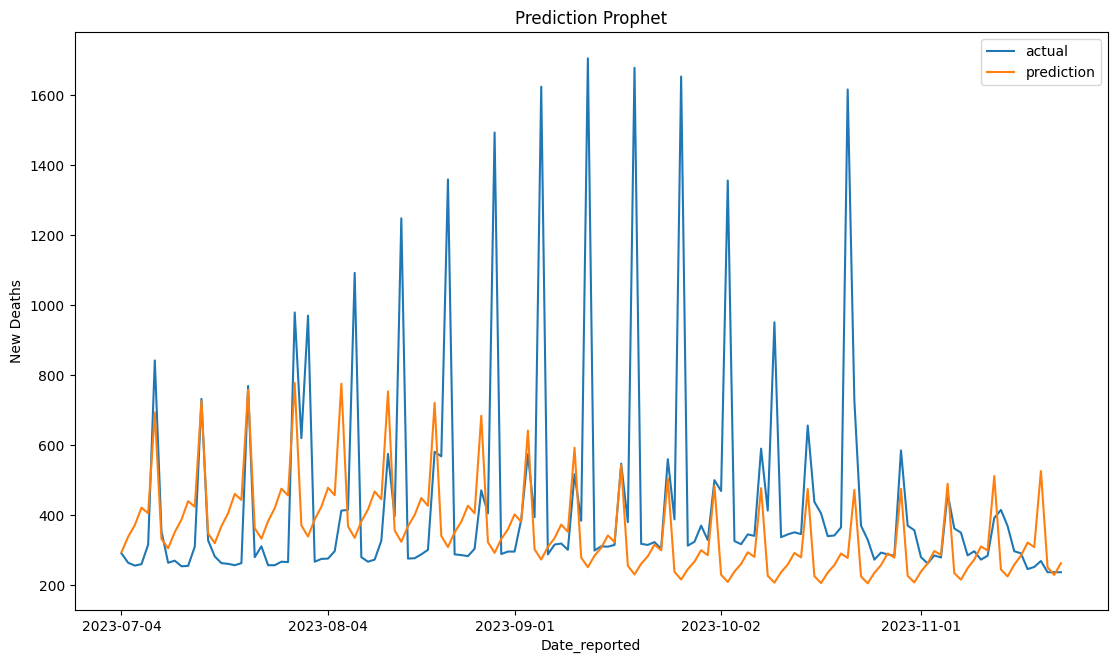

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [12]:
store_model(auto_model_log, "prophet_log")